# Action Type Classification

In [1]:
#TODO: Hyperparameter Tuning to improve lightgbm model's test score.

# Import Libraries

In [2]:
import nltk
nltk.download('stopwords')

import re
import pandas as pd
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Get Data

In [3]:
data_dir = "https://raw.githubusercontent.com/eteitelbaum/code-satp/refs/heads/main/data/action_type.csv"

data = pd.read_csv(data_dir)
data.head()

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction,incident_summary
0,0,1,0,0,0,0,0,An alleged arms supplier to the Communist Part...
1,0,0,0,0,1,0,0,A Kamareddy dalam (squad) member belonging to ...
2,0,1,0,0,0,0,0,Senior CPI-Maoist 'Polit Bureau' and 'central ...
3,1,0,0,0,0,0,0,A TDP leader and former Sarpanch of Jerrela Gr...
4,0,0,1,1,0,0,0,The CPI-Maoist cadres blasted coffee pulping u...


In [4]:
data["action_type"] = data.drop("incident_summary", axis = 1).idxmax(axis=1)
data.head()

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction,incident_summary,action_type
0,0,1,0,0,0,0,0,An alleged arms supplier to the Communist Part...,arrest
1,0,0,0,0,1,0,0,A Kamareddy dalam (squad) member belonging to ...,surrender
2,0,1,0,0,0,0,0,Senior CPI-Maoist 'Polit Bureau' and 'central ...,arrest
3,1,0,0,0,0,0,0,A TDP leader and former Sarpanch of Jerrela Gr...,armed_assault
4,0,0,1,1,0,0,0,The CPI-Maoist cadres blasted coffee pulping u...,bombing


<Axes: xlabel='action_type'>

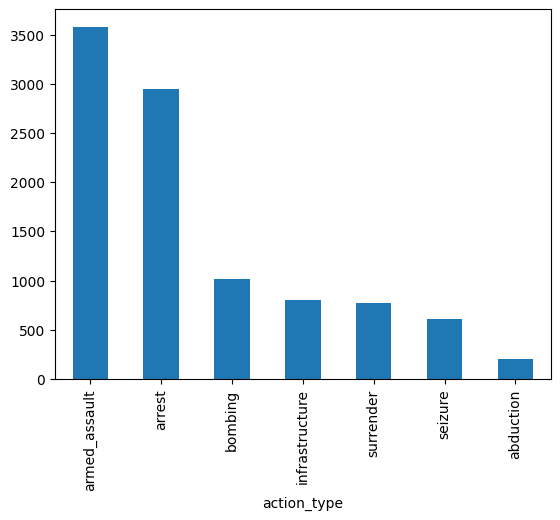

In [5]:
data["action_type"].value_counts().plot(kind = "bar")

In [6]:
data["action_type"].value_counts().to_dict()

{'armed_assault': 3577,
 'arrest': 2947,
 'bombing': 1012,
 'infrastructure': 803,
 'surrender': 774,
 'seizure': 607,
 'abduction': 201}

# Clean the Data

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z ]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        Params:
                text: input text

        Return:
                Cleaned text
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

data['summary_cleaned'] = data['incident_summary'].apply(clean_text)
data.head()

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction,incident_summary,action_type,summary_cleaned
0,0,1,0,0,0,0,0,An alleged arms supplier to the Communist Part...,arrest,alleged arms supplier communist party indiamao...
1,0,0,0,0,1,0,0,A Kamareddy dalam (squad) member belonging to ...,surrender,kamareddy dalam squad member belonging janasha...
2,0,1,0,0,0,0,0,Senior CPI-Maoist 'Polit Bureau' and 'central ...,arrest,senior cpimaoist polit bureau central committe...
3,1,0,0,0,0,0,0,A TDP leader and former Sarpanch of Jerrela Gr...,armed_assault,tdp leader former sarpanch jerrela gram pancha...
4,0,0,1,1,0,0,0,The CPI-Maoist cadres blasted coffee pulping u...,bombing,cpimaoist cadres blasted coffee pulping units ...


# Create splits

In [8]:
data.head(1)

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction,incident_summary,action_type,summary_cleaned
0,0,1,0,0,0,0,0,An alleged arms supplier to the Communist Part...,arrest,alleged arms supplier communist party indiamao...


In [9]:
X = data["summary_cleaned"]
y = data.iloc[:, 0:7]
strat = data["action_type"]
display(X.shape, y.shape, X.head(1), y.head(1))

(9921,)

(9921, 7)

,summary_cleaned
0,alleged arms supplier communist party indiamao...


,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction
0,0,1,0,0,0,0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=strat, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8928,), (993,), (8928, 7), (993, 7))

# Train a Logistic Regression Model (Multi-Label Classification)

In [11]:
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(LogisticRegression(class_weight="balanced")))
              ])
lr.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced')))])

In [12]:
train_preds_lr = lr.predict(X_train)
test_preds_lr = lr.predict(X_test)

preds_df_train_lr = pd.DataFrame(data=train_preds_lr, columns = y.columns)
preds_df_test_lr = pd.DataFrame(data=test_preds_lr, columns = y.columns)

# LgithGBM Model

In [13]:
lgbm = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(LGBMClassifier(is_unbalance = True, verbose = -1)))
              ])

lgbm.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=LGBMClassifier(is_unbalance=True,
                                                                verbose=-1)))])

In [14]:
train_preds_lgbm = lgbm.predict(X_train)
test_preds_lgbm = lgbm.predict(X_test)

preds_df_train_lgbm = pd.DataFrame(data=train_preds_lgbm, columns = y.columns)
preds_df_test_lgbm = pd.DataFrame(data=test_preds_lgbm, columns = y.columns)

# Evaluation

MLC Scores

In [15]:
print("Logistic Regression Train Accuracy:", lr.score(X_train, y_train))

Logistic Regression Train Accuracy: 0.8699596774193549


In [16]:
print("Logistic Regression Test Accuracy:", lr.score(X_test, y_test))

Logistic Regression Test Accuracy: 0.7754279959718026


In [17]:
print("LGBM Train Accuracy:", lgbm.score(X_train, y_train))

LGBM Train Accuracy: 0.975358422939068


In [18]:
print("LGBM Test Accuracy:", lgbm.score(X_test, y_test))

LGBM Test Accuracy: 0.8318227593152064


In [19]:
# How is the model performing of different labels

compare = preds_df_train_lgbm == y_train.reset_index(drop=True)

print("Training Scores:")
for i in range(compare.shape[1]):
  print(f"Label ({compare.columns[i]}) score: {(compare.iloc[:, i].sum()) / compare.shape[0]:.6f}")

Training Scores:
Label (armed_assault) score: 0.995968
Label (arrest) score: 0.999888
Label (bombing) score: 0.996192
Label (infrastructure) score: 0.996528
Label (surrender) score: 1.000000
Label (seizure) score: 0.985887
Label (abduction) score: 1.000000


In [20]:
# How is the model performing of different labels

compare = preds_df_test_lgbm == y_test.reset_index(drop=True)

print("Testing Scores:")
for i in range(compare.shape[1]):
  print(f"Label ({compare.columns[i]}) score: {(compare.iloc[:, i].sum()) / compare.shape[0]:.6f}")

Testing Scores:
Label (armed_assault) score: 0.966767
Label (arrest) score: 0.986908
Label (bombing) score: 0.966767
Label (infrastructure) score: 0.958711
Label (surrender) score: 0.998993
Label (seizure) score: 0.939577
Label (abduction) score: 0.984894


In [21]:
# Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score

print("Balanced Accuracy Scores:")
for i in range(y_test.shape[1]):
  y_true = y_test.iloc[:, i]
  y_pred = preds_df_test_lgbm.iloc[:, i]

  print(f"Label ({y_test.columns[i]}) score: {balanced_accuracy_score(y_true, y_pred):.6f}")

Balanced Accuracy Scores:
Label (armed_assault) score: 0.964877
Label (arrest) score: 0.985989
Label (bombing) score: 0.937153
Label (infrastructure) score: 0.893064
Label (surrender) score: 0.999454
Label (seizure) score: 0.919378
Label (abduction) score: 0.901189


SLC Scores (Predicitng atleast one event from the summary correctly)

In [22]:
#LG
corrects = (preds_df_train_lr.idxmax(axis=1) == y_train.reset_index(drop=True).idxmax(axis=1)).sum()
total = y_train.shape[0]
print(f"LR Train Accuracy: {corrects/total}")

LR Train Accuracy: 0.944108422939068


In [23]:
corrects = (preds_df_test_lr.idxmax(axis=1) == y_test.reset_index(drop=True).idxmax(axis=1)).sum()
total = y_test.shape[0]
print(f"LR Test Accuracy: {corrects/total}")

LR Test Accuracy: 0.8952668680765358


In [24]:
#LGBM
corrects = (preds_df_train_lgbm.idxmax(axis=1) == y_train.reset_index(drop=True).idxmax(axis=1)).sum()
total = y_train.shape[0]
print(f"LGBM Train Accuracy: {corrects/total}")

LGBM Train Accuracy: 0.9921594982078853


In [25]:
corrects = (preds_df_test_lgbm.idxmax(axis=1) == y_test.reset_index(drop=True).idxmax(axis=1)).sum()
total = y_test.shape[0]
print(f"LGBM Test Accuracy: {corrects/total}")

LGBM Test Accuracy: 0.9224572004028198


In [26]:
display(preds_df_test_lgbm.head(), y_test.head())

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0
3,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0


,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction
7849,1,0,0,0,0,0,0
8320,0,1,0,0,0,0,0
7727,1,0,0,0,0,1,0
1253,1,0,0,0,0,0,0
2067,0,1,0,0,0,0,0


# Testing with real samples

In [27]:
real_test = ["On January 5, at least three Special Operations Group (SOG) jawans (personnel) were injured when an Improvised Explosive Device (IED), suspected to have been planted by the Communist Party of India (CPI-Maoist), exploded during a combing operation in the Badepanga forests bordering Boudh-Kandhamal in the Boudh District of Odisha, reports The New Indian Express.",
             "A former Communist Party of India-Maoist (CPI-Maoist) cadre, identified as Pujari Ramudu alias Bheemanna (59), was found brutally beaten to death near RS Pendakal railway station in Kurnool District of Andhra Pradesh on January 6, reports jantaserishta.com. Pujari, a resident of RS Pendakal village, is also known to be the brother of Yuvajana Sramika Rythu Congress Party (YSRC) women's wing president and Member of the Legislative Council (MLC) Pothula Sunita. He was associated with the Maoist gang for 30 years. He later surrendered before the police in 1991 and started leading a normal life. On January 6, some unknown people attacked Ramudu with stones, due to which he died. After the incident, the attackers fled from the spot",
             "On January 6, a 25-year-old school teacher, identified as Ramlal Nureti, was arrested from Karekatta village under Madanwada Police Station limits in Mohla-Manpur-Ambagarh Chowki District of Chhattisgarh for allegedly being a Communist Party of India-Maoist (CPI-Maoist) supporter, reports Devdiscourse. Angered by the arrest, a group of villagers, including schoolchildren, have launched a protest in front of Sitagaon Police Station, demanding his release. Ramlal was allegedly involved in putting up Maoist banners and posters in the area in September last year, the Police said. On September 15, 2023, the police recovered posters and banners from the Madanwada area, where Maoists appealed to observe the 19th anniversary of the outlawed movement, the Police added.",
             "The Communist Party of India-Maoist (CPI-Maoist) cadres targeted a construction site and set ablaze at least three machines involved in soil cutting at Bariatu in Chandwa in the Latehar District of Jharkhand on January 6, reports The Avenue Mail. Kashyap Construction, responsible for the third railway line project in Bariatu, faced disruption as Poclain, JCB, and mixer machines were burned by the Maoists. Following the arson, at least seven rounds of firing were also reported, creating an atmosphere of fear and panic in the area.",
             "Vehicles engaged in bridge construction work on the Manak River in Kurumdari village in Simaria in Chatra District of Jharkhand were set on fire by cadres of the Communist Party of India-Maoist (CPI-Maoist) on January 6, reports The Avenue Mail."
             ]
real_cleaned = [clean_text(text) for text in real_test]

In [28]:
real_preds = lgbm.predict(real_cleaned)
pd.DataFrame(data=real_preds, columns = y.columns)

,armed_assault,arrest,bombing,infrastructure,surrender,seizure,abduction
0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
